In [29]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

homedir = os.getenv("HOME")
path_to_im = homedir+'/Desktop/im.png'

In [30]:
img_only = Image.open(path_to_im)
img = np.asarray(img_only)

height = np.shape(img)[0]
width = np.shape(img)[1]

In [31]:
def get_scaling_fraction(height,width):

    if height>width:
        fraction = width/height
        return 1, fraction
    elif width>height:
        fraction = height/width
        return fraction, 1
    elif width==height:
        return  1, 1
    else:
        print("I don't know what to tell ye. Your width and height are not numbers.")
        return None

In [32]:
#a hearty DANKE to stackexchange

#this function is mine; it helps ensure that pixel cells are square- and not rectangular-shaped
frac_h, frac_w = get_scaling_fraction(height,width)

#resize smoothly down to desired number of pixels for x (70*frac_w) and y (70*frac_h)
imgSmall = img_only.resize((int(70*frac_w),int(70*frac_h)), resample=Image.Resampling.BILINEAR)

#scale back up to original size, if desired...
#result = imgSmall.resize(img_only.size, resample=Image.Resampling.NEAREST)

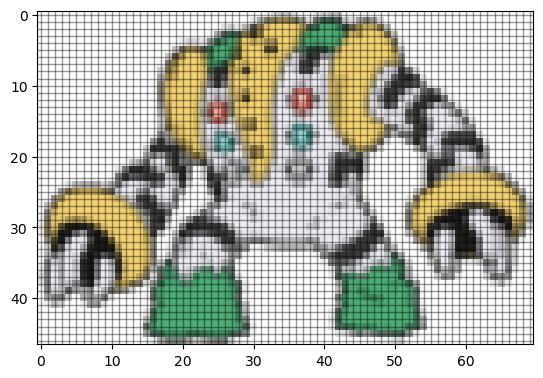

In [33]:
plt.imshow(imgSmall)
for i in range(np.shape(imgSmall)[0]):
    plt.axhline(i,lw=1,color='black',alpha=0.4)
for i in range(np.shape(imgSmall)[1]):
    plt.axvline(i,lw=1,color='black',alpha=0.4)

I clearly need to add a grid offset in order for it to align properly with the pixel cells. After a bit of testing, it appears that 0.35 is sufficient here...

In [34]:
def add_grid(image_array,spacing=0.35):
     
    for n in range(np.shape(image_array)[0]):
        plt.axhline(n+spacing,lw=1,color='black',alpha=0.4)
    for n in range(np.shape(image_array)[1]):
        plt.axvline(n+spacing,lw=1,color='black',alpha=0.4)    

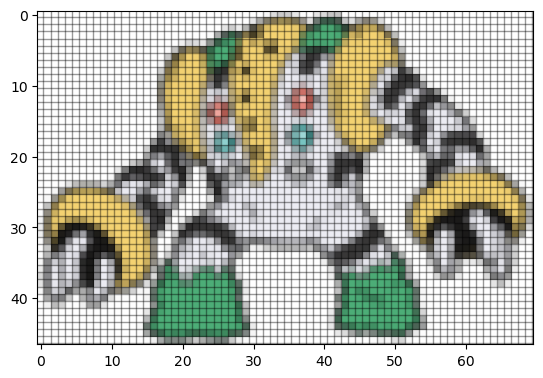

In [35]:
plt.imshow(imgSmall)
add_grid(imgSmall)

let's try one more image -- just for testing.

In [42]:
img_only = Image.open(homedir+'/Desktop/im2.png')
img = np.asarray(img_only)

height = np.shape(img)[0]
width = np.shape(img)[1]

In [43]:
frac_h, frac_w = get_scaling_fraction(height,width)

imgSmall = img_only.resize((int(74*frac_w),int(74*frac_h)), resample=Image.Resampling.BILINEAR)

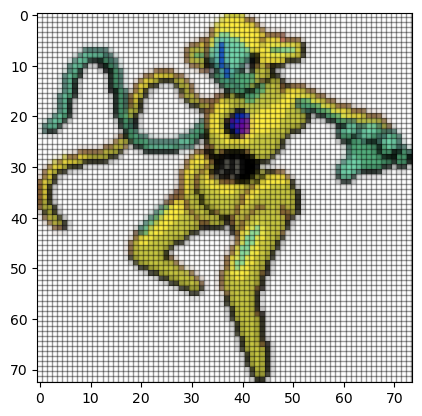

In [44]:
plt.imshow(imgSmall)
add_grid(imgSmall,spacing=0.35)

Okay. 0.35 it is. I'll go ahead and streamline this bugger.
HOWEVER --> when saving the images, it appears that a 0.5 offset is more effective at aligning the grid with the pixels. I do not make the rules.

In [45]:
!python ~/github/pixelate_png/pixelate.py -im_path ~/Desktop/im.png -nx 100 -grid_offset 0.5 - background gray

Image saved to Desktop.


# yay.

Let's next try to sharpen some of the images such that the borders and pixel transitions are better resolved (e.g., rather than black to gray to slightly less gray to white for the "edges" of an image, the transition is black to white).

In [46]:
#now we use the package opencv-python...
import cv2

#img = cv2.imread(path_to_im)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#let's take our new small image
imgt = np.asarray(imgSmall)

try:
    Z = imgt.reshape((-1, 4))
except:
    Z = imgt.reshape((-1,3))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2   #change this value to dictate the number of represented colors in the image.
ret, label, center = cv2.kmeans(Z, K, None, criteria, 20, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((imgt.shape))

#cv2.imwrite("./output.png", res2)

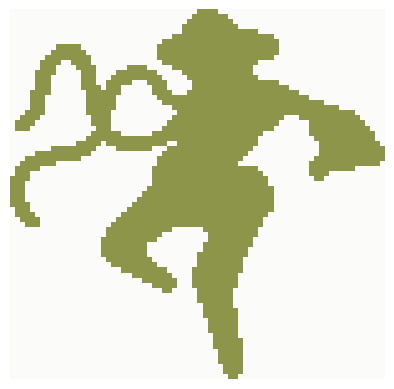

In [47]:
plt.imshow(res2)
plt.axis("off")
plt.show()

In [48]:
#Quite a binary result, yes (I did select K=2, after all). What if I converted this output into
#a boolean?!

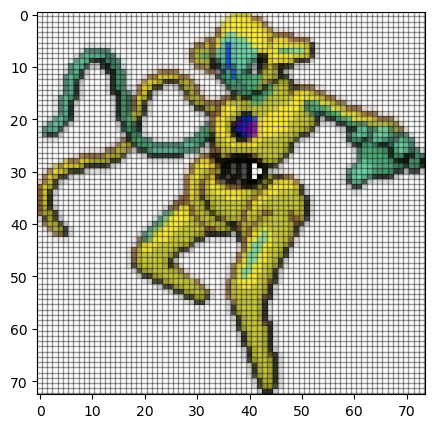

In [183]:
plt.rcParams['axes.facecolor'] = 'gray'

plt.figure(figsize=(5,5))
r = imgt[:,:,0]*(res2[:,:,0] < 250)
g = imgt[:,:,1]*(res2[:,:,1] < 250)
b = imgt[:,:,2]*(res2[:,:,2] < 250)
rgb = np.dstack((r,g,b))
rgb[rgb==0] = 255

plt.imshow(rgb)
add_grid(rgb)
plt.show()

Not so terrible, I suppose. <br>
(Note that I adjust the positioning of the axis labels in the actual script.)
### ALSO: please do use the unpixelated image as a color reference.

In [122]:
#SCRAP

I want the innards to be sharp as well, not only the perimeter!

In [349]:
#create the sharpening kernel 
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
#sharpen the image 
#gray_image = cv2.cvtColor(imgt, cv2.COLOR_RGB2GRAY) 
  

image2 = cv2.filter2D(imgt, -1, kernel) 

#backtorgb = cv2.cvtColor(image2,cv2.COLOR_GRAY2RGB)

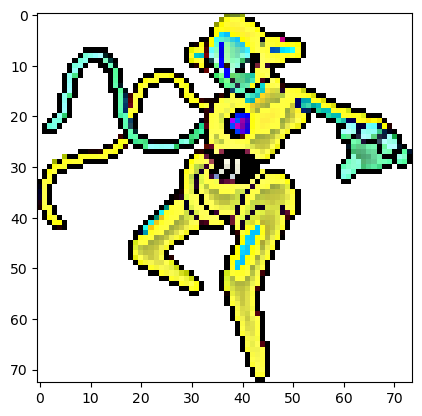

In [353]:
plt.imshow(image2)

In [212]:
#sort of closer?

In [360]:
from scipy.signal import convolve2d
matr = np.zeros(np.shape(imgt))
for i in range(3):
    matr[:, :, i] = convolve2d(imgt[:, :, i], kernel, mode='same', boundary='symm')

In [41]:
#quick approach to printing version of a python package
#!pip show opencv-python | grep Version

Edge detection: OpenCV provides several functions for performing edge detection, such as Canny(), Sobel(), and Laplacian(). These functions can be used to identify edges in an image by looking for sharp changes in pixel intensity. <br>

Image gradients: OpenCV provides several functions for computing image gradients, such as Scharr(), Sobel(), and Laplacian(). These functions can be used to highlight changes in pixel intensity in an image and can be useful for tasks such as edge detection and image segmentation.